In this notebook, we analyze the proprotions of ED vists for avoidable MSK conditions

In [2]:
if(!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, janitor, arrow, readxl, pairwiseCI, patchwork, svglite, ggupset, ggsci)

Loading required package: pacman


# Data

In [2]:
# MIMIC data
ed_data <- read_parquet(
     "../MIMICED/ed_join_cc.parquet"
    ) |>
    filter(icd_version==10, !is.na(age), age >= 19)  |> 
    distinct(subject_id, stay_id, .keep_all = T) |> 
    collect()

#ICD codes
mcodes <- read_csv(
    "mcodes.csv",
    show_col_types = F
    )
power_codes <- read_csv(
    "power_cms.csv",
    show_col_types = F
) 
hwa_codes <- read_csv(
    "hwa_joined.csv",
    show_col_types = F
)

ed_data <- ed_data |> 
    mutate(
        mcode = as.integer(primary_code %in% mcodes$cms_code),
        power = as.integer(primary_code %in% power_codes$cms_code),
        hwa = as.integer(primary_code %in% hwa_codes$cms_code),
        # add the nyu and res columns
        nyu_mcode = as.integer(mcode == 1 & nyu == 1),
        nyu_power = as.integer(power == 1 & nyu == 1),
        nyu_hwa = as.integer(hwa == 1 & nyu == 1),
        code_letter = str_sub(primary_code, 1, 1),
    )   |> 
    arrow_table()

New names:
• `` -> `...1`


In [3]:
# California data
cali_df  <- read_parquet("cali_df.parquet")
nyu_10  <- read_excel(
    "NYU ED Algorithm - ICD10 Codes - Updated 2.4.25.xlsx"
    ) |> 
    clean_names()  |> 
    rename(
        code = icd10,
        emergent_pc = emergent_pc_treatable
    ) |> 
    mutate(
        nyu_sum = map2_dbl(non_emergent, emergent_pc, ~sum(.x,.y)),
        nyu = if_else(nyu_sum>0.5, true = 1, false = 0)
    ) |> 
    filter(nyu==1)
cali_df <- cali_df |> 
    mutate(
        all = 1,
        mcode = as.integer(icd_code %in% mcodes$cms_code),
        power = as.integer(icd_code %in% power_codes$cms_code),
        hwa = as.integer(icd_code %in% hwa_codes$cms_code),
        nyu = as.integer(icd_code %in% nyu_10$code),
        nyu_mcode = as.integer(nyu==1 & mcode==1),
        nyu_power = as.integer(nyu==1 & power==1),
        nyu_hwa = as.integer(nyu==1 & hwa==1),
       code_letter = str_sub(icd_code, 1, 1)
    ) 


# Codes Analysis

# Data Analysis

### MIMIC dataset



Number of visits

In [4]:
rows <- nrow(ed_data |>collect() )
print(rows)

[1] 220352


Number of Distinct patients

In [5]:
print(ed_data |> 
    distinct(subject_id) |> 
    count() |> 
    collect())

# A tibble: 1 × 1
       n
   <int>
1 121088


Highest n visits by one patient

In [6]:
ed_data |> 
    group_by(subject_id) |> 
    summarise(visits = n()) |> 
    arrange(desc(visits)) |> 
    slice_head(n = 1) |> 
    collect() |> 
    select(visits) |> 
    print()

# A tibble: 1 × 1
  visits
   <int>
1    252


Age

In [7]:
print(ed_data |> 
    dplyr::select(age) |> 
    collect() |> 
    summarise(
        median_age = round(median(age)),
        iqr_age = IQR(age)
    ))


# A tibble: 1 × 2
  median_age iqr_age
       <dbl>   <dbl>
1         55      34


Gender

In [8]:
print(ed_data |> 
    group_by(gender) |>
    count() |>
    mutate("%" = round(n/rows*100)) |>
    collect())

# A tibble: 2 × 3
# Groups:   gender [2]
  gender      n   `%`
  <chr>   <int> <dbl>
1 M      102083    46
2 F      118269    54


Unclassified

In [9]:
unlcass <- function(colname){
  print(deparse(substitute(colname)))
  ed_data |> 
    collect() |>
    mutate(all =1) |> 
    select(unclassified, col = {{colname}}, primary_code) |> 
    filter(unclassified == 1, col == 1) |>
    distinct(primary_code) |>
    count() |> 
    print()
}
unlcass(all)
unlcass(mcode)
unlcass(power)
unlcass(hwa)

[1] "all"
# A tibble: 1 × 1
      n
  <int>
1  2964
[1] "mcode"
# A tibble: 1 × 1
      n
  <int>
1   492
[1] "power"
# A tibble: 1 × 1
      n
  <int>
1   479
[1] "hwa"
# A tibble: 1 × 1
      n
  <int>
1   107


## HCAI dataset

In [10]:
total_cases <-  sum(cali_df$primary_count)
print(paste("Total visits = ",total_cases))

[1] "Total visits =  54059693"


## Proportions Analysis

### MIMIC

#### Functions

In [11]:
contingency_f <- function(mcode_col, power_col, hwa_col){
  data <- ed_data |> 
    select(
      mcode = {{mcode_col}}, 
      power = {{power_col}}, 
      hwa = {{hwa_col}}) |>
      collect() |> 
      mutate(across(everything(), ~ case_when(
        .x == 1 ~ "In List",
        .x == 0 ~ "Not in List"
          )
        )
      ) 
  cat("\nmcode vs power:")
  data |> 
    select(mcode, power) |> 
    table() |> 
    print()
  
  cat("\nmcode vs hwa:")
  data |> 
    select(mcode, hwa) |> 
    table() |> 
    print()
  
  cat("\npower vs hwa:")
  data |> 
    select(power, hwa) |> 
    table() |> 
    print()
}

In [12]:
# Proportions function
prop_f <- function(df, col_name){
    cat("\n")
    print(deparse(substitute(col_name)))
    print(df |> 
        filter({{col_name}} == 1)  |> 
        collect() |> 
        count() |> 
        mutate(`%` = round(n/nrow(df)*100,2)))

}

In [13]:
# Difference in proprtions function
diff_function <- function(cols_in){
  m <- ed_data |> select(code = !!sym(cols_in[[1]]))  |> mutate(g = "mcode") |> collect()
  p <- ed_data |> select(code = !!sym(cols_in[[2]])) |>mutate(g = "power")|> collect()
  h <-  ed_data |> select(code = !!sym(cols_in[[3]]))  |>mutate(g = "hwa")|> collect()
  print(paste("Mean Mcode:", round(mean(m$code)*100,2)))
  cat("\n")
  print(paste("Mean power:", round(mean(p$code)*100,2)))
  cat("\n")
  print(paste("Mean hwa:",round(mean(h$code)*100,2)))
  mat_p <- bind_rows(m,p,h) |> mutate(g = factor(g))
  result  <- pairwiseCI(code ~ g, data = mat_p, method="Param.diff")$byout[[1]]
  df <- tibble(
    comp = result$compnames,
    estimate = result$estimate[result$compnames],
    lower = result$lower[result$compnames],
    upper = result$upper[result$compnames]
  ) |> 
  mutate(across(c(estimate, lower, upper), ~ round(.x *100, 2)))
  cat("\nCIs")
  print(df)
}

In [14]:
letter_function <- function(df, col_name){
  cat("\n")
  print(deparse(substitute(col_name)))
  df |> 
    mutate(all=1) |>
    filter({{col_name}} == 1)  |> 
    collect() |> 
    group_by(code_letter) |>
    count() |> 
    mutate(`%` = round(n/nrow(df)*100,2)) |> 
    arrange(desc(n)) |> 
    print()
}

#### Contingency

All ED visits

In [15]:
contingency_f(mcode, power, hwa)


mcode vs power:             power
mcode         In List Not in List
  In List       17383         110
  Not in List    9183      193676

mcode vs hwa:             hwa
mcode         In List Not in List
  In List       14105        3388
  Not in List   17605      185254

power vs hwa:             hwa
power         In List Not in List
  In List       19787        6779
  Not in List   11923      181863


Redirectable

In [16]:
contingency_f(nyu_mcode, nyu_power, nyu_hwa)


mcode vs power:             power
mcode         In List Not in List
  In List       13808          20
  Not in List       3      206521

mcode vs hwa:             hwa
mcode         In List Not in List
  In List       12406        1422
  Not in List    5085      201439

power vs hwa:             hwa
power         In List Not in List
  In List       12408        1403
  Not in List    5083      201458


#### Proportions

##### All ED visits

In [17]:
prop_f(ed_data,mcode)
prop_f(ed_data,power)
prop_f(ed_data,hwa)


[1] "mcode"
# A tibble: 1 × 2
      n   `%`
  <int> <dbl>
1 17493  7.94

[1] "power"
# A tibble: 1 × 2
      n   `%`
  <int> <dbl>
1 26566  12.1

[1] "hwa"
# A tibble: 1 × 2
      n   `%`
  <int> <dbl>
1 31710  14.4


In [18]:
letter_function(ed_data, all)
letter_function(ed_data, mcode)
letter_function(ed_data, power)
letter_function(ed_data, hwa)


[1] "all"
# A tibble: 22 × 3
# Groups:   code_letter [22]
   code_letter     n   `%`
   <chr>       <int> <dbl>
 1 R           51838 23.5 
 2 S           27032 12.3 
 3 K           18589  8.44
 4 I           18408  8.35
 5 M           17493  7.94
 6 F           15159  6.88
 7 J           12077  5.48
 8 N           10150  4.61
 9 T            9199  4.17
10 G            6479  2.94
# ℹ 12 more rows
# ℹ Use `print(n = ...)` to see more rows

[1] "mcode"
# A tibble: 1 × 3
# Groups:   code_letter [1]
  code_letter     n   `%`
  <chr>       <int> <dbl>
1 M           17493  7.94

[1] "power"
# A tibble: 2 × 3
# Groups:   code_letter [2]
  code_letter     n   `%`
  <chr>       <int> <dbl>
1 M           17383  7.89
2 S            9183  4.17

[1] "hwa"
# A tibble: 7 × 3
# Groups:   code_letter [7]
  code_letter     n   `%`
  <chr>       <int> <dbl>
1 M           14105  6.4 
2 S           12056  5.47
3 R            4851  2.2 
4 G             635  0.29
5 T              40  0.02
6 I              22

Differences

In [19]:
cols_in <- c("mcode", "power", "hwa")
diff_function(cols_in)

[1] "Mean Mcode: 7.94"

[1] "Mean power: 12.06"

[1] "Mean hwa: 14.39"

CIs# A tibble: 3 × 4
  comp        estimate lower upper
  <chr>          <dbl> <dbl> <dbl>
1 mcode-hwa      -6.45 -6.64 -6.27
2 power-hwa      -2.33 -2.53 -2.13
3 power-mcode     4.12  3.94  4.29


##### Potentially Avoidable Visits

In [20]:
prop_f(ed_data, nyu)
prop_f(ed_data,nyu_mcode)
prop_f(ed_data,nyu_power)
prop_f(ed_data,nyu_hwa)


[1] "nyu"
# A tibble: 1 × 2
      n   `%`
  <int> <dbl>
1 76481  34.7

[1] "nyu_mcode"
# A tibble: 1 × 2
      n   `%`
  <int> <dbl>
1 13828  6.28

[1] "nyu_power"
# A tibble: 1 × 2
      n   `%`
  <int> <dbl>
1 13811  6.27

[1] "nyu_hwa"
# A tibble: 1 × 2
      n   `%`
  <int> <dbl>
1 17491  7.94


In [21]:
letter_function(ed_data, nyu)
letter_function(ed_data, nyu_mcode)
letter_function(ed_data, nyu_power)
letter_function(ed_data, nyu_hwa)



[1] "nyu"
# A tibble: 18 × 3
# Groups:   code_letter [18]
   code_letter     n   `%`
   <chr>       <int> <dbl>
 1 R           34054 15.4 
 2 M           13828  6.28
 3 L            5000  2.27
 4 N            4703  2.13
 5 K            4658  2.11
 6 J            4166  1.89
 7 I            3065  1.39
 8 B            1310  0.59
 9 H            1162  0.53
10 Z            1133  0.51
11 G            1047  0.48
12 O             789  0.36
13 A             705  0.32
14 D             453  0.21
15 S             186  0.08
16 E             157  0.07
17 C              33  0.01
18 T              32  0.01

[1] "nyu_mcode"
# A tibble: 1 × 3
# Groups:   code_letter [1]
  code_letter     n   `%`
  <chr>       <int> <dbl>
1 M           13828  6.28

[1] "nyu_power"
# A tibble: 2 × 3
# Groups:   code_letter [2]
  code_letter     n   `%`
  <chr>       <int> <dbl>
1 M           13808  6.27
2 S               3  0   

[1] "nyu_hwa"
# A tibble: 4 × 3
# Groups:   code_letter [4]
  code_letter     n   `%`
  <chr

Differences

In [22]:
cols_in <- c("nyu_mcode", "nyu_power", "nyu_hwa")
diff_function(cols_in)

[1] "Mean Mcode: 6.28"

[1] "Mean power: 6.27"

[1] "Mean hwa: 7.94"

CIs# A tibble: 3 × 4
  comp        estimate lower upper
  <chr>          <dbl> <dbl> <dbl>
1 mcode-hwa      -1.66 -1.81 -1.51
2 power-hwa      -1.67 -1.82 -1.52
3 power-mcode    -0.01 -0.15  0.14


##### Sensitivity

Proportions

In [23]:
first_visit <- ed_data |>
  select(stay_id, subject_id, intime, mcode, power, hwa, nyu, nyu_mcode, nyu_power, nyu_hwa) |> 
  collect() |> 
  group_by(subject_id) |> 
  arrange(intime) |> 
  slice_head(n=1) |> 
  ungroup() |> 
  arrow_table()

print(paste("total visits:",nrow(first_visit)))
prop_f(first_visit, mcode)
prop_f(first_visit, power)
prop_f(first_visit, hwa)

[1] "total visits: 121088"

[1] "mcode"
# A tibble: 1 × 2
      n   `%`
  <int> <dbl>
1  9386  7.75

[1] "power"
# A tibble: 1 × 2
      n   `%`
  <int> <dbl>
1 16279  13.4

[1] "hwa"
# A tibble: 1 × 2
      n   `%`
  <int> <dbl>
1 19320  16.0


Redirectable

In [24]:
prop_f(first_visit, nyu)
prop_f(first_visit, nyu_mcode)
prop_f(first_visit, nyu_power)
prop_f(first_visit, nyu_hwa)



[1] "nyu"
# A tibble: 1 × 2
      n   `%`
  <int> <dbl>
1 40230  33.2

[1] "nyu_mcode"
# A tibble: 1 × 2
      n   `%`
  <int> <dbl>
1  7234  5.97

[1] "nyu_power"
# A tibble: 1 × 2
      n   `%`
  <int> <dbl>
1  7228  5.97

[1] "nyu_hwa"
# A tibble: 1 × 2
      n   `%`
  <int> <dbl>
1  9298  7.68


### HCAI

In [25]:
cali_f <- function(col_name){
    cat("\n")
    print(deparse(substitute(col_name)))
    sum_x <- sum(cali_df$primary_count)
    cali_df |> 
        filter({{col_name}}==1) |> 
        summarise(sum_visits = sum(primary_count)) |> 
        mutate(`%` = round(sum_visits/sum_x*100,1)) |> 
        print()
}
cali_f(all)
cali_f(mcode)
cali_f(power)
cali_f(hwa)



[1] "all"
# A tibble: 1 × 2
  sum_visits   `%`
       <dbl> <dbl>
1   54059693   100

[1] "mcode"
# A tibble: 1 × 2
  sum_visits   `%`
       <dbl> <dbl>
1    3832506   7.1

[1] "power"
# A tibble: 1 × 2
  sum_visits   `%`
       <dbl> <dbl>
1    6441309  11.9

[1] "hwa"
# A tibble: 1 × 2
  sum_visits   `%`
       <dbl> <dbl>
1    9821279  18.2


In [26]:
cali_f(nyu)
cali_f(nyu_mcode)
cali_f(nyu_power)
cali_f(nyu_hwa)


[1] "nyu"
# A tibble: 1 × 2
  sum_visits   `%`
       <dbl> <dbl>
1   25109221  46.4

[1] "nyu_mcode"
# A tibble: 1 × 2
  sum_visits   `%`
       <dbl> <dbl>
1    3013389   5.6

[1] "nyu_power"
# A tibble: 1 × 2
  sum_visits   `%`
       <dbl> <dbl>
1    3013148   5.6

[1] "nyu_hwa"
# A tibble: 1 × 2
  sum_visits   `%`
       <dbl> <dbl>
1    3971518   7.3


In [27]:
letter_function(cali_df, all)
letter_function(cali_df, mcode)
letter_function(cali_df, power)
letter_function(cali_df, hwa)


[1] "all"
# A tibble: 21 × 3
# Groups:   code_letter [21]
   code_letter     n   `%`
   <chr>       <int> <dbl>
 1 S           15881 39.1 
 2 T            4842 11.9 
 3 M            4308 10.6 
 4 H            2698  6.64
 5 O            1336  3.29
 6 Z            1225  3.01
 7 I            1207  2.97
 8 C            1019  2.51
 9 L             823  2.02
10 Q             796  1.96
# ℹ 11 more rows
# ℹ Use `print(n = ...)` to see more rows

[1] "mcode"
# A tibble: 1 × 3
# Groups:   code_letter [1]
  code_letter     n   `%`
  <chr>       <int> <dbl>
1 M            4308  10.6

[1] "power"
# A tibble: 2 × 3
# Groups:   code_letter [2]
  code_letter     n   `%`
  <chr>       <int> <dbl>
1 S            7847  19.3
2 M            4099  10.1

[1] "hwa"
# A tibble: 8 × 3
# Groups:   code_letter [8]
  code_letter     n   `%`
  <chr>       <int> <dbl>
1 S            8452 20.8 
2 M             646  1.59
3 G              22  0.05
4 I              20  0.05
5 R              10  0.02
6 T               4

In [28]:
letter_function(cali_df, nyu)
letter_function(cali_df, nyu_mcode)
letter_function(cali_df, nyu_power)
letter_function(cali_df, nyu_hwa)


[1] "nyu"
# A tibble: 18 × 3
# Groups:   code_letter [18]
   code_letter     n   `%`
   <chr>       <int> <dbl>
 1 M             424  1.04
 2 H             187  0.46
 3 L             187  0.46
 4 N              92  0.23
 5 R              85  0.21
 6 K              66  0.16
 7 Z              60  0.15
 8 B              53  0.13
 9 O              41  0.1 
10 J              37  0.09
11 I              34  0.08
12 A              22  0.05
13 G              21  0.05
14 E              19  0.05
15 P               4  0.01
16 Q               3  0.01
17 D               2  0   
18 C               1  0   

[1] "nyu_mcode"
# A tibble: 1 × 3
# Groups:   code_letter [1]
  code_letter     n   `%`
  <chr>       <int> <dbl>
1 M             424  1.04

[1] "nyu_power"
# A tibble: 1 × 3
# Groups:   code_letter [1]
  code_letter     n   `%`
  <chr>       <int> <dbl>
1 M             420  1.03

[1] "nyu_hwa"
# A tibble: 3 × 3
# Groups:   code_letter [3]
  code_letter     n   `%`
  <chr>       <int> <dbl>
1 M   

# Plots

Fig 1

In [37]:
stacked_f <- function (mcode_col, power_col, hwa_col, title_in, max_in) {
  data <- ed_data |> 
    select({{mcode_col}}, {{power_col}}, {{hwa_col}}) |> 
    collect()
  # Compute counts
  counts <- list(
    mcode = data |> filter({{ mcode_col }} == 1) |> nrow(),
    power_additional = data |> filter({{ power_col }} == 1, {{ mcode_col }} == 0) |> nrow(),
    hwa_additional = data |> filter({{ hwa_col }} == 1, {{ power_col }} == 0, {{ mcode_col }} == 0) |> nrow()
  )
  
  plot_data <- tribble(
    ~bar,   ~segment,      ~count,
    "M-Codes", "M-Codes",           counts$mcode,
    "M-Codes+\n PC-MSK Codes", "M-Codes",       counts$mcode,
    "M-Codes+\n PC-MSK Codes", "PC-MSK Codes",      counts$power_additional,
    "M-Codes+\n PC-MSK Codes+\n ED-MSK Codes", "M-Codes",           counts$mcode,
    "M-Codes+\n PC-MSK Codes+\n ED-MSK Codes", "PC-MSK Codes",      counts$power_additional,
    "M-Codes+\n PC-MSK Codes+\n ED-MSK Codes", "ED-MSK Codes",        counts$hwa_additional
  ) |> 
    mutate(
      bar = factor(bar, levels = c("M-Codes", "M-Codes+\n PC-MSK Codes",  "M-Codes+\n PC-MSK Codes+\n ED-MSK Codes")),
      segment = factor(segment, levels = c( "ED-MSK Codes","PC-MSK Codes", "M-Codes")),
    )
  
  
  # Plot
  p1 <- ggplot(plot_data, aes(x = bar, y = count, fill = segment)) +
    geom_bar(stat = "identity") +
    labs(
      x="",
      y = "Visits (N)",
      fill = ""
    ) +
    theme_minimal()+
    theme(
      panel.grid = element_blank(),
      legend.position="bottom",
      axis.line = element_line(color = "black"),
      axis.text = element_text(size = 9, colour = "black")
    )+
    scale_y_continuous(
      expand = expansion(mult = c(0, 0.05)),
      breaks = seq(0, max_in, by = 5000),
      limits = c(0, max_in)
    )+
    ggtitle(label = title_in)
  return(p1)
}

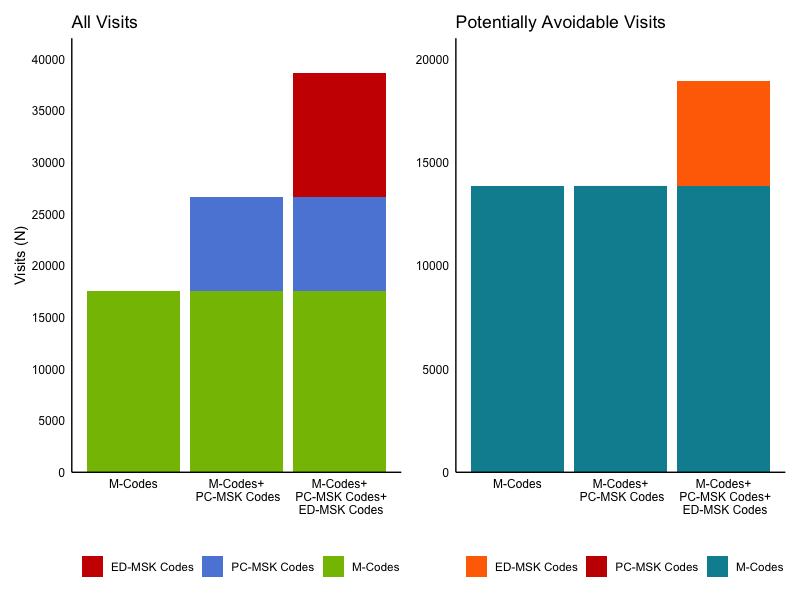

In [38]:
fig1_1a <- stacked_f(mcode,power,hwa, "All Visits", 40000)+scale_fill_startrek()
fig_1b <- stacked_f(nyu_mcode,nyu_power,nyu_hwa, "Potentially Avoidable Visits", 20000)+scale_fill_futurama()
fig1 <- (fig1_1a + fig_1b + plot_layout(axes = "collect")) 
ggsave("fig1.svg", fig1, device = "svg", width = 10, height=7, dpi=1200)
plot(fig1)

Fig 2

In [6]:
upset_f <- function(mcode_col, power_col, hwa_col, title_in, max_in){
data <- ed_data |> 
  select(
    mcode = all_of(mcode_col),
    power = all_of(power_col),
    hwa = all_of(hwa_col)
  ) |> 
  collect()
  
set_levels <- c("M-Codes", "PC-MSK codes", "ED-MSK codes")
  
 data_sets <-  data |>
    mutate(sets = pmap(list(mcode, power, hwa), function(mcode, power, hwa) {
    members <- c()
    if (mcode == 1) members <- c(members, "M-Codes")
    if (power == 1) members <- c(members, "PC-MSK codes")
    if (hwa == 1) members <- c(members, "ED-MSK codes")
    members
  }))

  p1 <- data_sets |> 
    filter(lengths(sets) > 0) |>
    mutate(set_size = lengths(sets)) |>
    ggplot(aes(x = sets, fill = factor(set_size))) +
    geom_bar() +
    scale_x_upset(sets = set_levels) +
    geom_text(stat="count", aes(label=after_stat(count)), vjust=-1)+
    scale_y_continuous(
      expand = expansion(mult = c(0, 0.05)),
      breaks = seq(0, max_in, by = 2500),
      limits = c(0, max_in)
    )+
    labs(x = "Set Intersections", y = "Count")+
    theme_minimal()+
    theme(
        legend.position = "none",
        panel.grid=element_blank(),
        axis.line = element_line(color = "black"),
        axis.text = element_text(size = 9, colour = "black")
      )+
    theme_combmatrix(combmatrix.label.text = element_text(size = 10, colour = "black"))+ # Set the font size for matrix
    labs(
      x="",
      y="Visits (N)"
    )+

    ggtitle(label=title_in)
  
  return(p1)
}


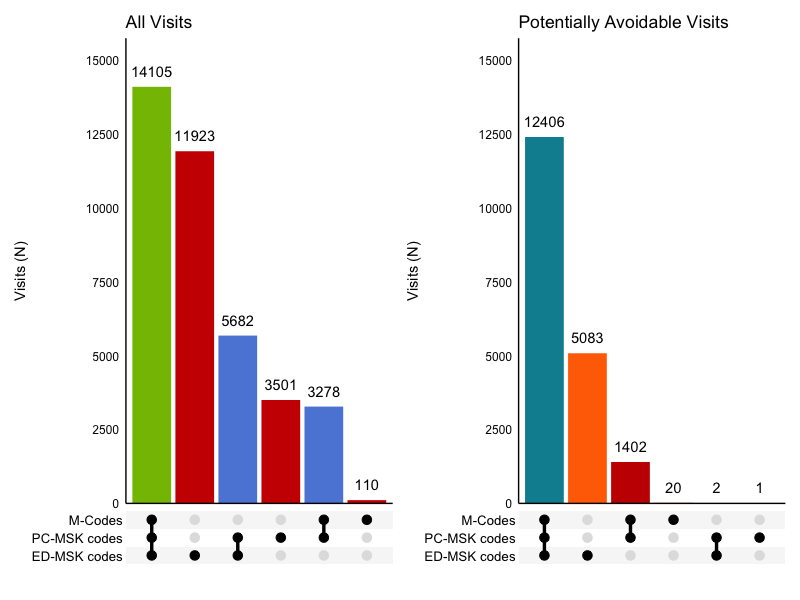

In [8]:
fig_2a <- upset_f("mcode", "power", "hwa", "All Visits", 15000)+scale_fill_startrek()
fig_2b <- upset_f("nyu_mcode", "nyu_power", "nyu_hwa", "Potentially Avoidable Visits", 15000)+scale_fill_futurama()
fig2 <- (fig_2a + fig_2b + plot_layout(guides = "collect")) 
ggsave("fig2.svg", fig2, device = "svg", width = 10, height=7, dpi=1200)
ggsave("fig2.png", fig2, device = "png", width = 10, height=7, dpi=1200)
plot(fig2)

# save results

In [33]:
# save mimic data frame
write_parquet(ed_data, "mimic_data.parquet")

# save california data frame
write_parquet(cali_df, "cali_data.parquet")